In [1]:
import numpy as np
import pickle
import skimage.transform
import scipy
import numpy as np
import theano
import theano.tensor as T
from theano import config
import matplotlib.pyplot as plt
%matplotlib inline
floatX=theano.config.floatX

In [2]:
from nn import ConvLayer
from theano.tensor.signal import pool
IMAGE_W = 600
class vgg19(object):
    def __init__(self, input, width_1):
        self.input=input.reshape((1,3,width_1,width_1))
        rng=np.random.RandomState(11)
        self.layers={}
        
        self.conv1_1 = ConvLayer(rng,
            input=self.input,
            image_shape=(1, 3, width_1, width_1),
            filter_shape=(64, 3, 3, 3),
            border_mode=1
        )
        self.conv1_2 = ConvLayer(
            rng,
            input=self.conv1_1.output,
            image_shape=(1, 64, width_1, width_1),
            filter_shape=(64, 64, 3, 3),
            border_mode=1
        )
        self.pool1 = pool.pool_2d(
            input=self.conv1_2.output,
            ds=(2,2),
            mode = 'average_exc_pad',
            ignore_border = True
        )
        width_2 = width_1/2


        self.conv2_1 = ConvLayer(
            rng,
            input=self.pool1,
            image_shape=(1, 64, width_2, width_2),
            filter_shape=(128, 64, 3, 3),
            border_mode=1
        )
        self.conv2_2  = ConvLayer(
            rng,
            input=self.conv2_1.output,
            image_shape=(1, 128, width_2, width_2),
            filter_shape=(128, 128, 3, 3),
            border_mode=1
        )
        self.pool2 = pool.pool_2d(
                input=self.conv2_2.output,
                ds=(2,2),
                mode = 'average_exc_pad',
                ignore_border = True
        )    
        width_3 = width_2/2
        
        self.conv3_1 = ConvLayer(
            rng,
            input=self.pool2,
            image_shape=(1, 128, width_3, width_3),
            filter_shape=(256, 128, 3, 3),
            border_mode=1
        )
        
        self.conv3_2 = ConvLayer(
            rng,
            input=self.conv3_1.output,
            image_shape=(1, 256, width_3, width_3),
            filter_shape=(256, 256, 3, 3),
            border_mode=1
        )
        self.conv3_3 = ConvLayer(
            rng,
            input=self.conv3_2.output,
            image_shape=(1, 256, width_3, width_3),
            filter_shape=(256, 256, 3, 3),
            border_mode=1
        )

        self.conv3_4 = ConvLayer(
            rng,
            input=self.conv3_3.output,
            image_shape=(1, 256, width_3, width_3),
            filter_shape=(256, 256, 3, 3),
            border_mode=1
        )
        self.pool3 = pool.pool_2d(
                input=self.conv3_4.output,
                ds=(2,2),
                mode = 'average_exc_pad',
                ignore_border = True
        ) 
        width_4 = width_3/2
        self.conv4_1 = ConvLayer(
            rng,
            input=self.pool3,
            image_shape=(1, 256, width_4, width_4),
            filter_shape=(512, 256, 3, 3),
            border_mode=1
        )
        self.conv4_2 = ConvLayer(
            rng,
            input=self.conv4_1.output,
            image_shape=(1, 512, width_4, width_4),
            filter_shape=(512, 512, 3, 3),
            border_mode=1
        )
        self.conv4_3 = ConvLayer(
            rng,
            input=self.conv4_2.output,
            image_shape=(1, 512, width_4, width_4),
            filter_shape=(512, 512, 3, 3),
            border_mode=1
        )

        self.conv4_4 = ConvLayer(
            rng,
            input=self.conv4_3.output,
            image_shape=(1, 512, width_4, width_4),
            filter_shape=(512, 512, 3, 3),
            border_mode=1
        )
        self.pool4 = pool.pool_2d(
                input=self.conv4_4.output,
                ds=(2,2),
                mode = 'average_exc_pad',
                ignore_border = True
        ) 
        width_5 = width_4/2
        self.conv5_1 = ConvLayer(
            rng,
            input=self.pool4,
            image_shape=(1, 512, width_5, width_5),
            filter_shape=(512, 512, 3, 3),
            border_mode=1
        )
        self.conv5_2 = ConvLayer(
            rng,
            input=self.conv5_1.output,
            image_shape=(1, 512, width_5, width_5),
            filter_shape=(512, 512, 3, 3),
            border_mode=1
        )
        self.conv5_3 = ConvLayer(
            rng,
            input=self.conv5_2.output,
            image_shape=(1, 512, width_5, width_5),
            filter_shape=(512, 512, 3, 3),
            border_mode=1
        )

        self.conv5_4 = ConvLayer(
            rng,
            input=self.conv5_3.output,
            image_shape=(1, 512, width_5, width_5),
            filter_shape=(512, 512, 3, 3),
            border_mode=1
        )
        self.pool5 = pool.pool_2d(
                input=self.conv5_4.output,
                ds=(2,2),
                mode='average_exc_pad',
                ignore_border = True
            
        )
        self.output=self.pool5
        self.layers['conv1_1']=self.conv1_1
        self.layers['conv1_2']=self.conv1_2
        self.layers['conv2_1']=self.conv2_1
        self.layers['conv2_2']=self.conv2_2
        self.layers['conv3_1']=self.conv3_1
        self.layers['conv3_2']=self.conv3_2
        self.layers['conv3_3']=self.conv3_3
        self.layers['conv3_4']=self.conv3_4
        self.layers['conv4_1']=self.conv4_1
        self.layers['conv4_2']=self.conv4_2
        self.layers['conv4_3']=self.conv4_3
        self.layers['conv4_4']=self.conv4_4
        self.layers['conv5_1']=self.conv5_1
        self.layers['conv5_2']=self.conv5_2
        self.layers['conv5_3']=self.conv5_3
        self.layers['conv5_4']=self.conv5_4

    def set_params(self,values):
        i=0
        for name_key in self.layers.keys():
            self.layers[name_key].set_param(values[i],values[i+1])
            i=i+2

In [3]:
#!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg19_normalized.pkl

In [4]:

# build VGG net and load weights

# net = build_model()

values = pickle.load(open('vgg19_normalized.pkl'))['param values']
np.matrix(values).shape
# lasagne.layers.set_all_param_values(net['pool5'], values)

(1, 32)

In [5]:

photo = plt.imread('../../data/Tuebingen_Neckarfront.jpg')


In [6]:
#!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg19_normalized.pkl


In [7]:
def build_model():
    X=T.matrix('X')
    conv_layer=vgg19(X,IMAGE_W)
    conv_layer.set_params(values)
    #InputLayer((1, 3, IMAGE_W, IMAGE_W))
    net=conv_layer.layers
    net['input']= conv_layer.input 
    net['pool5'] =conv_layer.output
    return conv_layer,net


In [8]:
# build VGG net and load weights
values = pickle.load(open('vgg19_normalized.pkl'))['param values']
conv_layer,net = build_model()


In [9]:
MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))

def prep_image(im):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (IMAGE_W, w*IMAGE_W/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*IMAGE_W/w, IMAGE_W), preserve_range=True)

    # Central crop
    h, w, _ = im.shape
    im = im[h//2-IMAGE_W//2:h//2+IMAGE_W//2, w//2-IMAGE_W//2:w//2+IMAGE_W//2]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert RGB to BGR
    im = im[::-1, :, :]

    im = im - MEAN_VALUES
    return rawim, np.asarray(
                im[np.newaxis],
                dtype=theano.config.floatX
            )

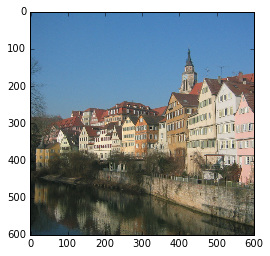

In [10]:
photo = plt.imread('../../data/Tuebingen_Neckarfront.jpg')
rawim, photo = prep_image(photo)
plt.imshow(rawim)

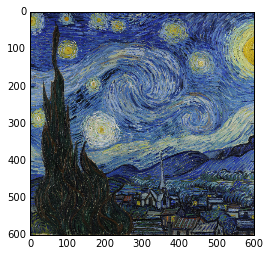

In [11]:
art = plt.imread('../../data/1920px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')
rawim, art = prep_image(art)
plt.imshow(rawim)

In [12]:
def gram_matrix(x):
    x = x.flatten(ndim=3)
    g = T.tensordot(x, x, axes=([2], [2]))
    return g


def content_loss(P, X, layer):
    p = P[layer]
    x = X[layer]
    
    loss = 1./2 * ((x - p)**2).sum()
    return loss


def style_loss(A, X, layer):
    a = A[layer]
    x = X[layer]
    
    A = gram_matrix(a)
    G = gram_matrix(x)
    
    N = a.shape[1]
    M = a.shape[2] * a.shape[3]
    
    loss = 1./(4 * N**2 * M**2) * ((G - A)**2).sum()
    return loss

def total_variation_loss(x):
    return (((x[:,:,:-1,:-1] - x[:,:,1:,:-1])**2 + (x[:,:,:-1,:-1] - x[:,:,:-1,1:])**2)**1.25).sum()

In [13]:
layers = ['conv4_2', 'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

In [14]:

conv_layer=vgg19(photo, IMAGE_W)
conv_layer.set_params(values)
net=conv_layer.layers
net['input']= conv_layer.input 
net['pool5'] =conv_layer.output

photo_features = {}
for k in layers:
    photo_features[k] = theano.shared(np.asarray(net[k].output.eval(), dtype = theano.config.floatX))
    #photo_features[k] = net[k].output

conv_layer=vgg19(art, IMAGE_W)
conv_layer.set_params(values)
net=conv_layer.layers
net['input']= conv_layer.input 
net['pool5'] =conv_layer.output

art_features = {}
for k in layers:
    art_features[k] = theano.shared(np.asarray(net[k].output.eval(), dtype = theano.config.floatX))


In [15]:
# Get expressions for layer activations for generated image
generated_image = theano.shared(np.asarray(np.random.uniform(-128, 128, (1, 3, IMAGE_W, IMAGE_W)), 
                                          dtype = theano.config.floatX))


conv_layer=vgg19(generated_image, IMAGE_W)
conv_layer.set_params(values)
net=conv_layer.layers
net['input']= conv_layer.input 
net['pool5'] =conv_layer.output

gen_features = {}
for k in layers:
    gen_features[k] = net[k].output

In [16]:
# Define loss function
losses = []

# content loss
losses.append(0.001 * content_loss(photo_features, gen_features, 'conv4_2'))

# style loss
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv1_1'))
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv2_1'))
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv3_1'))
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv4_1'))
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv5_1'))

# total variation penalty
losses.append(0.1e-7 * total_variation_loss(generated_image))

total_loss = sum(losses)

In [17]:
grad = T.grad(total_loss, generated_image)

In [18]:
grad

Elemwise{add,no_inplace}.0

In [19]:
# Theano functions to evaluate loss and gradient
f_loss = theano.function([], total_loss)
f_grad = theano.function([], grad)

# Helper functions to interface with scipy.optimize
def eval_loss(x0):
    x0 = np.asarray(x0.reshape((1, 3, IMAGE_W, IMAGE_W)),dtype = theano.config.floatX)
    generated_image.set_value(x0)
    return f_loss().astype('float64')

def eval_grad(x0):
    x0 = np.asarray(x0.reshape((1, 3, IMAGE_W, IMAGE_W)),dtype = theano.config.floatX)
    generated_image.set_value(x0)
    return np.array(f_grad()).flatten().astype('float64')


In [20]:
generated_image.set_value(np.asarray(np.random.uniform(-128, 128, (1, 3, IMAGE_W, IMAGE_W)), 
                                     dtype = theano.config.floatX))

x0 = generated_image.get_value().astype('float64')
xs = []
xs.append(x0)

# Optimize, saving the result periodically
for i in range(8):
    print(i)
    scipy.optimize.fmin_l_bfgs_b(eval_loss, x0.flatten(), fprime=eval_grad, maxfun=40)
    x0 = generated_image.get_value().astype('float64')
    xs.append(x0)

0
1


KeyboardInterrupt: 

In [28]:
def deprocess(x):
    x = np.copy(x[0])
    x += MEAN_VALUES

    x = x[::-1]
    x = np.swapaxes(np.swapaxes(x, 0, 1), 1, 2)
    
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [ ]:
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.gca().xaxis.set_visible(False)    
    plt.gca().yaxis.set_visible(False)    
    plt.imshow(deprocess(xs[i]))
plt.tight_layout()

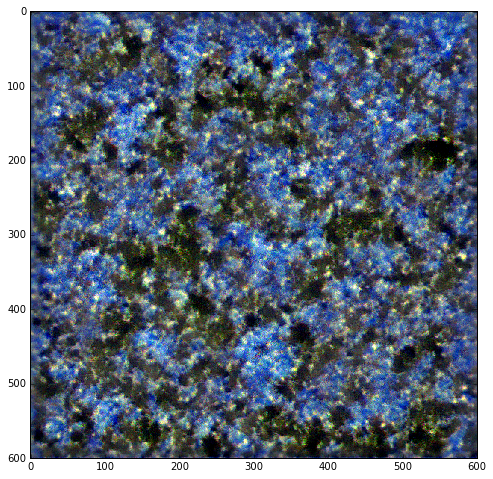

In [29]:
plt.figure(figsize=(8,8))
plt.imshow(deprocess(xs[-1]), interpolation='nearest')

In [ ]:
values[0].shape

In [ ]:
64*3*3*3

In [25]:
len(xs)

2